https://www.kaggle.com/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
category_names = pd.read_csv('category_names.csv')
category_names.columns = ['ItemCategoryId', 'ItemCategoryName']

item_categories = pd.read_csv('item_categories.csv')
item_categories.columns = ['ItemId', 'ItemCategoryId']

sales_history = pd.read_csv('sales_history.csv')
sales_history.columns = ['Date', 'StoreId', 'ItemId', 'ItemPrice', 'SoldNum']
sales_history['Date'] = pd.to_datetime(sales_history['Date'])

test = pd.read_csv('test.csv')
test.columns = ['index', 'ItemId', 'StoreId']
#item_categories['ItemCategoryId'].unique()
#category_names.query('ItemCategoryName.str.contains("")')
sales_history.shape

(1119570, 5)

In [3]:
target_item = test['ItemId'].unique()
test_item = pd.DataFrame({'ItemId':target_item})

In [4]:
test_list = test.groupby(['StoreId','ItemId']).sum()
test_list =test_list.reset_index()
test_list.drop(['index'],axis=1)

,StoreId,ItemId
0,0,1000001
1,0,1000002
2,0,1000003
3,0,1000004
4,0,1000005
...,...,...
3055,17,3300001
3056,17,3400001
3057,17,3400002
3058,17,3400003


170品目絞込

In [5]:
ttest = pd.merge(test,item_categories, on='ItemId')
ttest = pd.merge(ttest, category_names,on='ItemCategoryId')
print('予測データの品目数: ',ttest['ItemId'].nunique(),'\n',
      '訓練データの品目数: ',sales_history['ItemId'].nunique(),'\n',
      '予測データのカテゴリ数: ',item_categories['ItemCategoryId'].nunique(),'\n',
      '訓練データのカテゴリ数: ',ttest['ItemCategoryId'].nunique(),'\n',
     '売上の総数: ',sales_history['SoldNum'].sum(), '\n',
     '')


予測データの品目数:  170 
 訓練データの品目数:  9040 
 予測データのカテゴリ数:  26 
 訓練データのカテゴリ数:  26 
 売上の総数:  1262869.0 
 


In [6]:
sales_history = pd.merge(sales_history,test_item, on="ItemId",how='right')
sales_history['YYYYMM'] = sales_history['Date'].dt.strftime('%Y%m')

sales_history = sales_history.groupby(['YYYYMM','StoreId','ItemId']).agg(
    {'SoldNum':sum,'ItemPrice':'mean'}).reset_index()
sales_history

,YYYYMM,StoreId,ItemId,SoldNum,ItemPrice
0,201801,0,1000001,6.0,420.0
1,201801,0,1000002,2.0,250.0
2,201801,0,1000004,1.0,120.0
3,201801,0,1000005,8.0,220.0
4,201801,0,1000006,2.0,190.0
...,...,...,...,...,...
25402,201910,17,2900075,6.0,590.0
25403,201910,17,3200001,1.0,3720.0
25404,201910,17,3200026,4.0,850.0
25405,201910,17,3400001,1.0,850.0


In [7]:
sales_history = pd.pivot_table(sales_history,
               index=['ItemId','StoreId'],
               columns='YYYYMM',values='SoldNum')

In [8]:
sales_history.fillna(0.0,inplace=True)

In [9]:
sales_history = sales_history.reset_index()

In [10]:
sales_history = pd.merge(sales_history,test_list,on=['ItemId','StoreId'],how='right').fillna(0)

In [11]:
sales_history = sales_history.drop('index',axis=1)

In [12]:
sales_history.sort_values(['ItemId','StoreId']).reset_index().drop('index',axis=1)

,ItemId,StoreId,201801,201802,201803,201804,201805,201806,201807,201808,...,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910
0,1000001,0,6.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,...,2.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
1,1000001,1,2.0,1.0,0.0,2.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000001,2,1.0,0.0,1.0,0.0,1.0,2.0,3.0,4.0,...,0.0,2.0,1.0,1.0,0.0,2.0,0.0,3.0,0.0,2.0
3,1000001,3,2.0,0.0,3.0,8.0,2.0,1.0,4.0,6.0,...,5.0,2.0,3.0,2.0,5.0,4.0,5.0,6.0,3.0,2.0
4,1000001,4,0.0,2.0,1.0,2.0,2.0,4.0,6.0,2.0,...,4.0,8.0,6.0,3.0,5.0,6.0,9.0,14.0,8.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,3500001,13,1.0,2.0,1.0,0.0,3.0,2.0,1.0,3.0,...,0.0,2.0,1.0,0.0,2.0,1.0,1.0,1.0,3.0,2.0
3056,3500001,14,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3057,3500001,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3058,3500001,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Forecast特徴量　LSTM
https://www.kaggle.com/karanjakhar/simple-and-easy-aprroach-using-lstm


In [13]:
sales_test= sales_history.drop(['StoreId','ItemId'],axis=1)

In [14]:
# 2019/8月までのデータで９－１０月の2か月予測する
X_train = np.expand_dims(sales_test.values[:,:10],axis=2)
y_train = sales_test.values[:,10:12]

#testは最初の2列を除いた残りのデータ
X_test = np.expand_dims(sales_test.values[:,12:],axis=2)

print(X_train.shape,y_train.shape,X_test.shape)

(3060, 10, 1) (3060, 2) (3060, 10, 1)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
'''
https://www.kaggle.com/dimitreoliveira/time-series-forecasting-with-lstm-autoencoders
Regular LSTM
'''
lr = 0.01 # lr　に少し大きめの値を設定しておく (デフォルトは lr =0.001)
epochs = 100
batch_size = 128
adam = optimizers.Adam(lr)

model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(10,1),return_sequences=True))
model_lstm.add(LSTM(32, activation='relu',return_sequences=True))
model_lstm.add(LSTM(2, activation='relu'))
model_lstm.add(Dense(10,kernel_initializer='glorot_normal',activation='relu'))
model_lstm.add(Dense(10,kernel_initializer='glorot_normal',activation='relu'))
model_lstm.add(Dense(2))
model_lstm.compile(loss='mse',
                   optimizer=adam, 
                   metrics=['mean_squared_error'])
model_lstm.summary()

C:\Users\kmtk49\Anaconda3\envs\signate_Ai_Quest_submission\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kmtk49\Anaconda3\envs\signate_Ai_Quest_submission\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kmtk49\Anaconda3\envs\signate_Ai_Quest_submission\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\U

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 2)                 280       
_________________________________________________________________
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 29,754
T

https://analytics-note.xyz/machine-learning/reduce-lr-on-plateau/

In [16]:
early_stopping = EarlyStopping(
                        monitor='val_loss',
                        min_delta=0.0,
                        patience=10,
                )

# val_lossの改善が2エポック見られなかったら、学習率を0.5倍する。
reduce_lr = ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=0.5,
                        patience=2,
                        min_lr=0.0001
                )
model_lstm.fit(X_train,y_train,
               epochs = epochs,
               batch_size =batch_size,
              callbacks=[early_stopping, reduce_lr]
              )

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3060/3060 [==============================] - 2s 638us/sample - loss: 4.8501 - mean_squared_error: 4.8501
Epoch 2/100
3060/3060 [==============================] - 0s 116us/sample - loss: 2.9286 - mean_squared_error: 2.9286
Epoch 3/100
3060/3060 [==============================] - 0s 115us/sample - loss: 3.0204 - mean_squared_error: 3.0204
Epoch 4/100
3060/3060 [==============================] - 0s 111us/sample - loss: 2.8146 - mean_squared_error: 2.8146
Epoch 5/100
3060/3060 [==============================] - 0s 117us/sample - loss: 2.6086 - mean_squared_error: 2.6086
Epoch 6/100
3060/3060 [==============================] - 0s 117us/sample - loss: 2.9744 - mean_squared_error: 2.9744
Epoch 7/100
3060/3060 [==============================] - 0s 119us/sample - loss: 2.5137 - mean_squared_error: 2.5137
Epoch 8/100
3060/3060 [==============================] - 0s 123us/sample - loss: 2.6520 - mean_squared_error: 2.6520
Epoch 9/100
3060

Epoch 17/100
3060/3060 [==============================] - 0s 135us/sample - loss: 2.3023 - mean_squared_error: 2.3023
Epoch 18/100
3060/3060 [==============================] - 0s 140us/sample - loss: 2.3070 - mean_squared_error: 2.3070
Epoch 19/100
3060/3060 [==============================] - 0s 132us/sample - loss: 2.4910 - mean_squared_error: 2.4910
Epoch 20/100
3060/3060 [==============================] - 0s 112us/sample - loss: 2.4418 - mean_squared_error: 2.4418
Epoch 21/100
3060/3060 [==============================] - 0s 114us/sample - loss: 2.3858 - mean_squared_error: 2.3858
Epoch 22/100
3060/3060 [==============================] - 0s 119us/sample - loss: 2.5932 - mean_squared_error: 2.5932
Epoch 23/100
3060/3060 [==============================] - 0s 122us/sample - loss: 2.3638 - mean_squared_error: 2.3638
Epoch 24/100
3060/3060 [==============================] - 0s 118us/sample - loss: 2.2891 - mean_squared_error: 2.2891
Epoch 25/100
3060/3060 [==============================] 

3060/3060 [==============================] - 0s 117us/sample - loss: 2.2102 - mean_squared_error: 2.2102
Epoch 34/100
3060/3060 [==============================] - 0s 118us/sample - loss: 2.1617 - mean_squared_error: 2.1617
Epoch 35/100
3060/3060 [==============================] - 0s 118us/sample - loss: 2.2839 - mean_squared_error: 2.2839
Epoch 36/100
3060/3060 [==============================] - 0s 117us/sample - loss: 2.2216 - mean_squared_error: 2.2216
Epoch 37/100
3060/3060 [==============================] - 0s 111us/sample - loss: 2.2558 - mean_squared_error: 2.2558
Epoch 38/100
3060/3060 [==============================] - 0s 114us/sample - loss: 2.1053 - mean_squared_error: 2.1053
Epoch 39/100
3060/3060 [==============================] - 0s 115us/sample - loss: 2.0871 - mean_squared_error: 2.0871
Epoch 40/100
3060/3060 [==============================] - 0s 115us/sample - loss: 2.1243 - mean_squared_error: 2.1243
Epoch 41/100
3060/3060 [==============================] - 0s 116us/sa

Epoch 50/100
3060/3060 [==============================] - 0s 117us/sample - loss: 1.8468 - mean_squared_error: 1.8468
Epoch 51/100
3060/3060 [==============================] - 0s 118us/sample - loss: 1.8467 - mean_squared_error: 1.8467
Epoch 52/100
3060/3060 [==============================] - 0s 118us/sample - loss: 1.8392 - mean_squared_error: 1.8392
Epoch 53/100
3060/3060 [==============================] - 0s 116us/sample - loss: 1.8308 - mean_squared_error: 1.8308
Epoch 54/100
3060/3060 [==============================] - 0s 120us/sample - loss: 1.8387 - mean_squared_error: 1.8387
Epoch 55/100
3060/3060 [==============================] - 0s 122us/sample - loss: 1.8237 - mean_squared_error: 1.8237
Epoch 56/100
3060/3060 [==============================] - 0s 121us/sample - loss: 1.7853 - mean_squared_error: 1.7853
Epoch 57/100
3060/3060 [==============================] - 0s 124us/sample - loss: 1.7916 - mean_squared_error: 1.7916
Epoch 58/100
3060/3060 [==============================] 

3060/3060 [==============================] - 0s 119us/sample - loss: 1.7289 - mean_squared_error: 1.7289
Epoch 67/100
3060/3060 [==============================] - 0s 118us/sample - loss: 1.7116 - mean_squared_error: 1.7116
Epoch 68/100
3060/3060 [==============================] - 0s 118us/sample - loss: 1.6924 - mean_squared_error: 1.6924
Epoch 69/100
3060/3060 [==============================] - 0s 117us/sample - loss: 1.6796 - mean_squared_error: 1.6796
Epoch 70/100
3060/3060 [==============================] - 0s 111us/sample - loss: 1.6723 - mean_squared_error: 1.6723
Epoch 71/100
3060/3060 [==============================] - 0s 116us/sample - loss: 1.6457 - mean_squared_error: 1.6457
Epoch 72/100
3060/3060 [==============================] - 0s 117us/sample - loss: 1.6502 - mean_squared_error: 1.6502
Epoch 73/100
3060/3060 [==============================] - 0s 116us/sample - loss: 1.6312 - mean_squared_error: 1.6312
Epoch 74/100
3060/3060 [==============================] - 0s 115us/sa

Epoch 83/100
3060/3060 [==============================] - 0s 120us/sample - loss: 1.5923 - mean_squared_error: 1.5923
Epoch 84/100
3060/3060 [==============================] - 0s 118us/sample - loss: 1.6142 - mean_squared_error: 1.6142
Epoch 85/100
3060/3060 [==============================] - 0s 119us/sample - loss: 1.5673 - mean_squared_error: 1.5673
Epoch 86/100
3060/3060 [==============================] - 0s 122us/sample - loss: 1.5941 - mean_squared_error: 1.5941
Epoch 87/100
3060/3060 [==============================] - 0s 117us/sample - loss: 1.6289 - mean_squared_error: 1.6289
Epoch 88/100
3060/3060 [==============================] - 0s 121us/sample - loss: 1.6829 - mean_squared_error: 1.6829
Epoch 89/100
3060/3060 [==============================] - 0s 128us/sample - loss: 1.7801 - mean_squared_error: 1.7801
Epoch 90/100
3060/3060 [==============================] - 0s 126us/sample - loss: 1.9739 - mean_squared_error: 1.9739
Epoch 91/100
3060/3060 [==============================] 

3060/3060 [==============================] - 0s 120us/sample - loss: 1.4503 - mean_squared_error: 1.4503
Epoch 100/100
3060/3060 [==============================] - 0s 118us/sample - loss: 1.4566 - mean_squared_error: 1.4566


In [17]:
pred = model_lstm.predict(X_test)
sub = pd.DataFrame({'res':pred[:,1]})

sub.to_csv('./sub/submission_lstm02.csv',header=False)

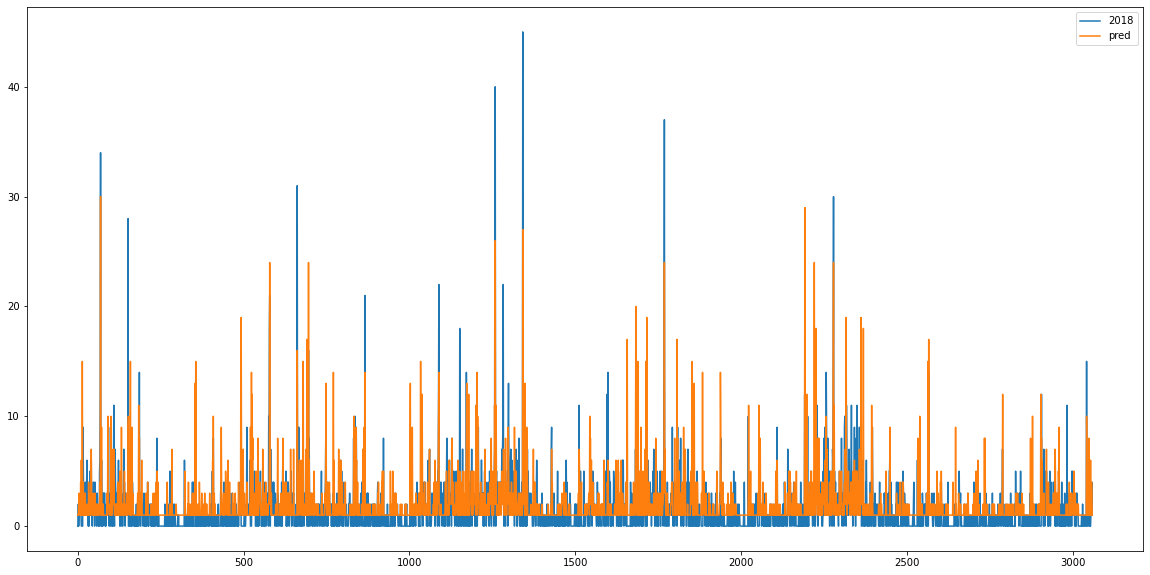

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(y_train[:,1],label='2018')
ax.plot(sub,label= 'pred')
ax.legend()
plt.show()

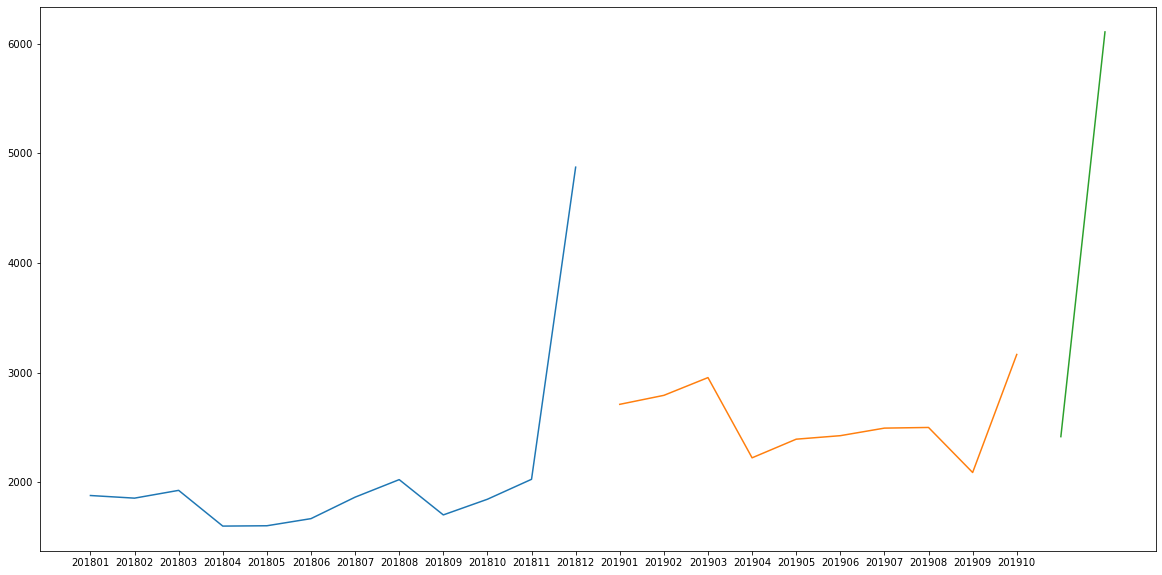

In [24]:
pred_sum = pred.sum(axis=0)
monthly_sales = sales_test.sum(axis=0)
last_year = monthly_sales[:12]
this_year = monthly_sales[12:]

plt.subplots(figsize=(20,10))
plt.plot(last_year)
plt.plot(this_year)
plt.plot(range(22,24),pred_sum)

res    6354.0
dtype: float32